In [2]:
import sqlite3 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    return run_query ('SELECT name, type FROM sqlite_master WHERE type IN ("table","view");')
     
    
show_tables()    

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [3]:
q1 = '''
WITH us_customers AS
    (
        SELECT 
            g.name genre
        FROM invoice_line il 
        INNER JOIN invoice i ON il.invoice_id = i.invoice_id
        INNER JOIN track t ON il.track_id = t.track_id
        INNER JOIN genre g ON t.genre_id = g.genre_id
        WHERE billing_country = 'USA' 
    )
    
SELECT 
    genre,
    COUNT(genre) numbersold,
    CAST(COUNT(genre) as float) / (SELECT COUNT(genre) FROM us_customers) percentage
FROM us_customers
GROUP BY genre
ORDER BY numbersold desc
'''
run_query(q1)


,genre,numbersold,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


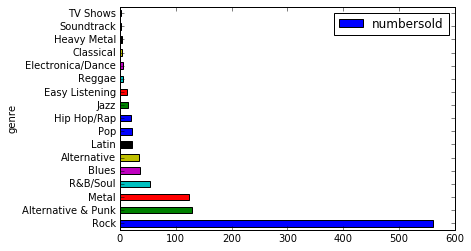

In [4]:
genre_sales_us = run_query(q1)
genre_sales_us.plot(kind='barh', x = 'genre', y = 'numbersold')

## Findings
According to the data, Rock music accounts for more than 50% of our sales. Punk, Blues, and Pop account for ~12%, ~3%, and ~2% of our sales respectively. We should choose Punk, Blues, and Pop if we based which albums to sell on the sales of genres.  

In [5]:
q2='''
SELECT
    e.first_name || " " || e.last_name employee_name,
    SUM(i.total) sales,
    e.hire_date
FROM invoice i
INNER JOIN customer c ON i.customer_id = c.customer_id
INNER JOIN employee e ON c.support_rep_id = e.employee_id
GROUP BY c.support_rep_id
'''
run_query(q2)

,employee_name,sales,hire_date
0,Jane Peacock,1731.51,2017-04-01 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00


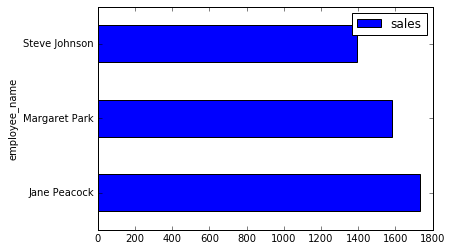

In [6]:
employee_performance=run_query(q2)
employee_performance.plot(kind='barh', x='employee_name')


## Findings
Although Steven Johnson has the least amount in sales, they also have been more recently hired compared to the others.

In [7]:
q3='''
WITH countryorother AS
(
    SELECT 
        CASE
            WHEN (SELECT COUNT(*)
            FROM customer
            WHERE country = c.country
            ) = 1 THEN "Other"
            ELSE c.country
        END AS country,
        c.customer_id,
        SUM(i.total) total,
        AVG(i.total) avgtotal
    FROM customer c
    INNER JOIN invoice i ON c.customer_id = i.customer_id
    GROUP BY c.customer_id
),

orderedbytotal AS
(
SELECT
    co.country,
    SUM(co.total) total,
    AVG(co.total) avgpercust,
    AVG(co.avgtotal) avgperorder
FROM countryorother co
GROUP BY co.country
ORDER BY total DESC
)

SELECT 
    country,
    total,
    avgpercust,
    avgperorder
FROM (
SELECT 
    *,
    CASE 
    WHEN country = 'Other' THEN 1
    ELSE 0
    END AS sort
FROM orderedbytotal
)
ORDER BY sort

'''

run_query(q3)

,country,total,avgpercust,avgperorder
0,USA,1040.49,80.037692,8.014750
1,Canada,535.59,66.948750,7.416238
2,Brazil,427.68,85.536000,6.987485
3,France,389.07,77.814000,7.835000
4,Germany,334.62,83.655000,8.188750
5,Czech Republic,273.24,136.620000,9.377500
6,United Kingdom,245.52,81.840000,8.749583
7,Portugal,185.13,92.565000,6.527813
8,India,183.15,91.575000,8.757692
9,Other,1094.94,72.996000,7.445071


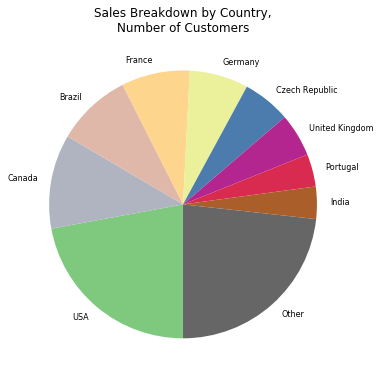

In [8]:
import numpy as np
sales_by_country = run_query(q3)
sales_by_country.set_index("country", drop=True, inplace=True)
pieplot = sales_by_country.plot.pie(
    y = 'total',
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0},
    legend=False,
    figsize=(6,6))
pieplot.set_ylabel('')

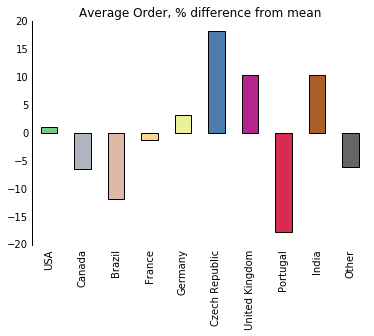

In [9]:
mean = np.mean(sales_by_country['avgperorder'])
differencefrommean = sales_by_country['avgperorder'] * 100 / mean - 100
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, sales_by_country.shape[0])]
bargraph = differencefrommean.plot(
    kind='bar',
    color=colors,
    title='Average Order, % difference from mean'
)
bargraph.tick_params(top="off", right="off", left="off", bottom="off")
bargraph.spines["top"].set_visible(False)
bargraph.spines["right"].set_visible(False)
bargraph.spines["bottom"].set_visible(False)
bargraph.set_xlabel("")

Although the United States make up most of the sales for Chinook, the Czech Republic, United Kingdom, and India are countries that should be looked into for marketing. However, it should be noted that due to the small sample size, smaller marketing campaigns should be ran first to test the true potential of these countries. 

In [13]:
run_query('''
WITH first_track AS
(
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1 
)
 
SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ft.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ft.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ft.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ft.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ft.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM first_track ft
    )
GROUP BY album_purchase;

''')

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


## Findings
Given that individual tracks account for 81.4% of sales and album purchases account for 18.6% of sales, I would advise against selling only individual tracks because of the possiblity of losing 1/5 of sales. 